In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [60]:
df = pd.read_excel('../Data/1645792390_cep1_dataset.xlsx')
df = pd.DataFrame(df)

In [61]:
# From the unique value table
num_var = ['age', 'restbps', 'chol', 'thalach', 'oldpeak']
cat_var = ['sex', 'cp', 'fast_bsug', 'rest_ecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [62]:
df.columns = ['age', 'sex', 'cp', 'restbps', 'chol', 'fast_bsug', 'rest_ecg','thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

In [63]:
df["thal"] = df["thal"].replace(0, np.nan)
df['thal'].fillna(df["thal"].median(), inplace=True)

In [64]:
cat_axis_name = ["Gender", "Chest Pain", "Fasting Blood Sugar", "resting ECG", "Exercise induced Angina", "Slope of ST Segment", "Number of Blood Vessels", "Thal", "Target"]
num_axis = ['age', 'resting blood pressure', 'cholesterol level', 'thalach', 'oldpeak', 'has CVD']

# Machine Learning model
### removing low correlated variables
* cholesterol, fasting blood sugar, rest ECG correlate very low
* resting blood pressure low correlation, but leave because numeric variable
* decide to remove or keep vars based on what think will contribute to accuracy of model

In [65]:
df.head()

,age,sex,cp,restbps,chol,fast_bsug,rest_ecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1.0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2.0,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2.0,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2.0,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2.0,1


In [66]:
df.drop(["chol", "fast_bsug", "rest_ecg"],axis=1, inplace=True)

In [67]:
num_var

['age', 'restbps', 'chol', 'thalach', 'oldpeak']

### Finding the outliers

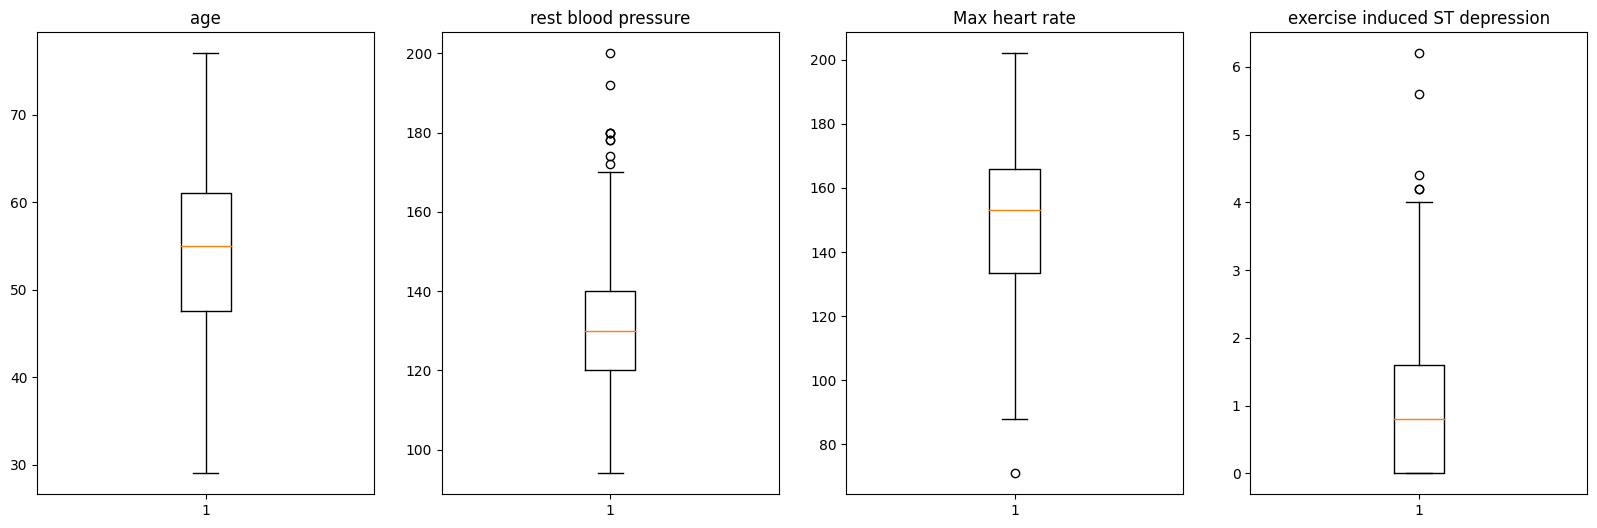

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

ax1.boxplot(df["age"])
ax1.set_title("age")

ax2.boxplot(df["restbps"])
ax2.set_title("rest blood pressure")

ax3.boxplot(df["thalach"])
ax3.set_title("Max heart rate")

ax4.boxplot(df["oldpeak"])
ax4.set_title("exercise induced ST depression")

plt.show()

#### Data Analysis
* oldpeak --  right skew, many outliers 
* Max heart rate -- normal distribution, few outliers
* Resting blood pressure -- outliers though seems to be somewhat normally distributed 

In [69]:
from scipy import stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

* zscore works well if data normally distributed
* outliers are those that are more the 3 SD from average, that is a zscore > 3

In [70]:
z_score_rbp = zscore(df['restbps'])
for threshold in range(1, 4):
    print("Threshold value: {}".format(threshold))
    print("Number of Outliers: {}".format(len(np.where(z_score_rbp > threshold)[0])))
    print("--------------------------------------")

Threshold value: 1
Number of Outliers: 51
--------------------------------------
Threshold value: 2
Number of Outliers: 13
--------------------------------------
Threshold value: 3
Number of Outliers: 2
--------------------------------------


* to find best threshold of outliers, for loop of zscores = 1, 2, 3 and see how many points outside each range
* with threshold =  3 get only 2 points outside this range, so will use threshold = 2

In [71]:
df[z_score_rbp > 2][["restbps"]]

,restbps
8,172
101,178
110,180
152,170
195,170
203,180
223,200
228,170
241,174
248,192


* delete outliers if few outliers and reason to believe would affect data much
* value assignment -- assign values as mean or median 
* winzorize -- distributes outliers thoughout the data based on statistical weights of none outlier data

In [72]:
df[z_score_rbp > 2][["restbps"]].min()

restbps    170
dtype: int64

In [73]:
df[df["restbps"] < 170].restbps.max()

165

* lowest value above the 2 standard deviation = 170
* the highest value below 2 SD = 165

In [74]:
winz_perc_rbp = (stats.percentileofscore(df['restbps'], 165))/100
winz_perc_rbp

0.957095709570957

In [75]:
1-winz_perc_rbp

0.04290429042904298

* with 165 as upper limit covers 95.7% of data 
* this only excludes 4.3% of data

In [76]:
rbp_winz = winsorize(df.restbps, (0, (1 - winz_perc_rbp)))

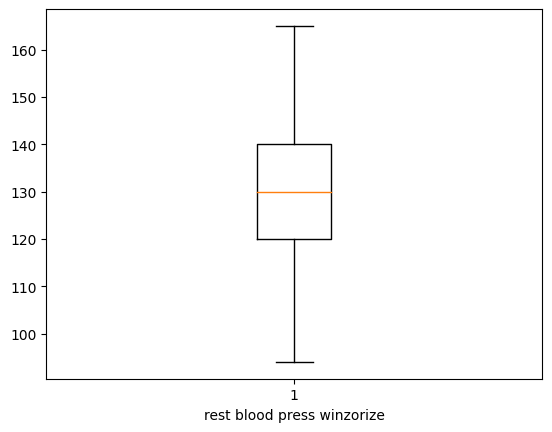

In [77]:
plt.boxplot(rbp_winz)
plt.xlabel("rest blood press winzorize")
plt.show()

In [78]:
df['rbp_winz'] = rbp_winz

In [79]:
df.head()

,age,sex,cp,restbps,thalach,exang,oldpeak,slope,ca,thal,target,rbp_winz
0,63,1,3,145,150,0,2.3,0,0,1.0,1,145
1,37,1,2,130,187,0,3.5,0,0,2.0,1,130
2,41,0,1,130,172,0,1.4,2,0,2.0,1,130
3,56,1,1,120,178,0,0.8,2,0,2.0,1,120
4,57,0,0,120,163,1,0.6,2,0,2.0,1,120


In [80]:
num_var

['age', 'restbps', 'chol', 'thalach', 'oldpeak']

#### Function that gives rows with value of variable outliers
* upper limit -- 3rd quartile + 1.5*IQR (the range between q1 and q3 is the inner quartile range)
* lower limit -- 1st quartile -1.5*IQR  

In [81]:
def iqr(df, var):
    q1 = np.quantile(df[var], 0.25)
    q3 = np.quantile(df[var], 0.75)
    diff = q3 - q1
    lower_v = q1 - 1.5*diff
    upper_v = q3 + 1.5*diff

    return  df[(df[var] < lower_v) | (df[var] > upper_v)]

In [82]:
iqr(df, "thalach")

,age,sex,cp,restbps,thalach,exang,oldpeak,slope,ca,thal,target,rbp_winz
272,67,1,0,120,71,0,1.0,1,0,2.0,0,120


In [83]:
df.describe()["thalach"].T

C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\alvancim\AppData\Roaming\Python

count    303.000000
mean     149.646865
std       22.905161
min       71.000000
25%      133.500000
50%      153.000000
75%      166.000000
max      202.000000
Name: thalach, dtype: float64

* Here see variable thalach has only one value below q1 - 1.5*IQR
* This is 71 at index = 272
* thalach has no values above q3 - 1.5*IQR
* This makes sense as look at descibe 133.5 - 1.5*(166-133) = 84, so any values below 84 is an outlier
* As it is only one row, can be dropped 

In [84]:
df.drop([272], axis=0, inplace=True)

In [85]:
iqr(df, "thalach")

,age,sex,cp,restbps,thalach,exang,oldpeak,slope,ca,thal,target,rbp_winz


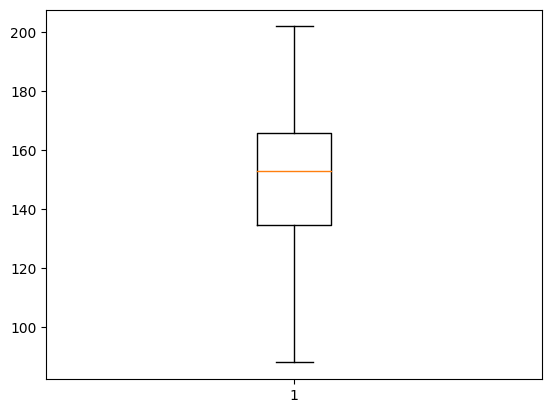

In [86]:
plt.boxplot(df['thalach'])
plt.show()

In [87]:
iqr(df, "oldpeak")

,age,sex,cp,restbps,thalach,exang,oldpeak,slope,ca,thal,target,rbp_winz
101,59,1,3,178,145,0,4.2,0,0,3.0,1,165
204,62,0,0,160,145,0,6.2,0,3,3.0,0,160
221,55,1,0,140,111,1,5.6,0,0,3.0,0,140
250,51,1,0,140,122,1,4.2,1,3,3.0,0,140
291,58,1,0,114,140,0,4.4,0,3,1.0,0,114


In [88]:
df.describe()['oldpeak']

count    302.000000
mean       1.039735
std        1.163000
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64

### finding closes value to upper limit outlier 
* observe  from function output 4.2 lowest value outlier
* need to find next  lowest value = 4.0
* Because of many outlier values, will use winzorize method 

In [89]:
df[df["oldpeak"] < 4.2].oldpeak.max()

4.0

In [90]:
win_perc_oldpk = (stats.percentileofscore(df['oldpeak'], 4))/100
win_perc_oldpk

0.980132450331126

In [91]:
oldpk_win = winsorize(df.oldpeak, (0, (1-win_perc_oldpk)))

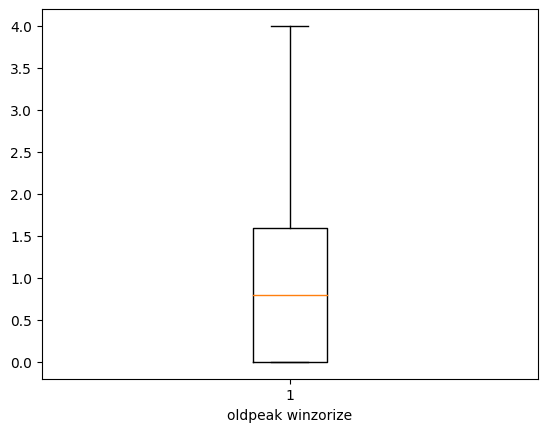

In [92]:
plt.boxplot(oldpk_win)
plt.xlabel('oldpeak winzorize')
plt.show()

In [93]:
df["oldpeak_winz"] = oldpk_win

In [94]:
df.head()

,age,sex,cp,restbps,thalach,exang,oldpeak,slope,ca,thal,target,rbp_winz,oldpeak_winz
0,63,1,3,145,150,0,2.3,0,0,1.0,1,145,2.3
1,37,1,2,130,187,0,3.5,0,0,2.0,1,130,3.5
2,41,0,1,130,172,0,1.4,2,0,2.0,1,130,1.4
3,56,1,1,120,178,0,0.8,2,0,2.0,1,120,0.8
4,57,0,0,120,163,1,0.6,2,0,2.0,1,120,0.6


In [95]:
df.drop(['restbps', "oldpeak"], axis=1, inplace=True)

In [96]:
df.columns

Index(['age', 'sex', 'cp', 'thalach', 'exang', 'slope', 'ca', 'thal', 'target',
       'rbp_winz', 'oldpeak_winz'],
      dtype='object')

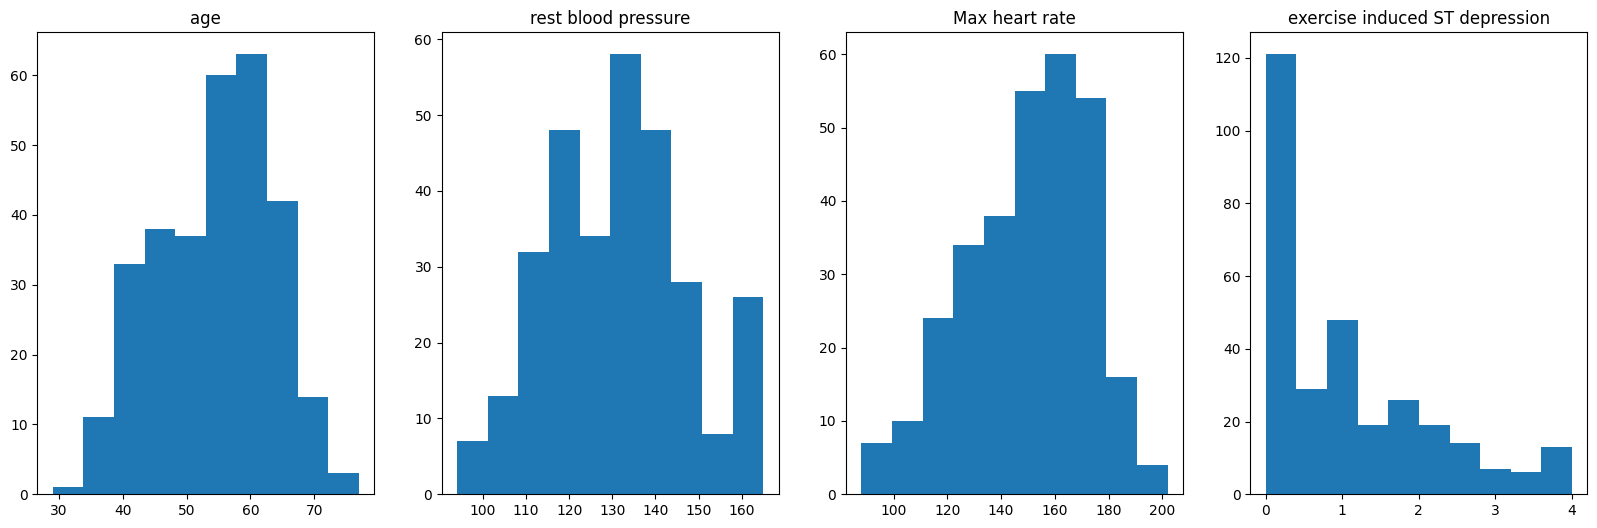

In [97]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

ax1.hist(df["age"])
ax1.set_title("age")

ax2.hist(df["rbp_winz"])
ax2.set_title("rest blood pressure")

ax3.hist(df["thalach"])
ax3.set_title("Max heart rate")

ax4.hist(df["oldpeak_winz"])
ax4.set_title("exercise induced ST depression")

plt.show()

In [98]:
df[['age', 'rbp_winz', 'thalach', 'oldpeak_winz']].agg(['skew']).T

,skew
age,-0.199209
rbp_winz,0.251969
thalach,-0.461611
oldpeak_winz,0.996036


### Tranform unsymetric data
* log of values
* square root of values

In [99]:
df['oldpeak_winz_log'] = np.log(df['oldpeak_winz'])
df['oldpeak_winz_sqrt'] = np.sqrt(df['oldpeak_winz'])

C:\Users\alvancim\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [100]:
df[["oldpeak_winz", "oldpeak_winz_log", "oldpeak_winz_sqrt"]].agg(["skew"]).T

,skew
oldpeak_winz,0.996036
oldpeak_winz_log,NaN
oldpeak_winz_sqrt,0.108926


In [101]:
df.drop(["oldpeak_winz", "oldpeak_winz_log"], axis=1, inplace=True)

In [102]:
df.head()

,age,sex,cp,thalach,exang,slope,ca,thal,target,rbp_winz,oldpeak_winz_sqrt
0,63,1,3,150,0,0,0,1.0,1,145,1.516575
1,37,1,2,187,0,0,0,2.0,1,130,1.870829
2,41,0,1,172,0,2,0,2.0,1,130,1.183216
3,56,1,1,178,0,2,0,2.0,1,120,0.894427
4,57,0,0,163,1,2,0,2.0,1,120,0.774597


# Catagorical Variables: One Hot Encoding
* copy df
* use get Dummies to transform cat vars to numerical 


In [103]:
df_copy = df.copy()

#### remove fasting blood sugar and resting ECG from cat_var

In [104]:
cat_var.remove("fast_bsug")
cat_var.remove("rest_ecg")

In [105]:
cat_var

['sex', 'cp', 'exang', 'slope', 'ca', 'thal', 'target']

In [106]:
df_copy = pd.get_dummies(df_copy, columns=cat_var[:-1], drop_first = True)

In [107]:
df_copy.head()

,age,thalach,target,rbp_winz,oldpeak_winz_sqrt,sex_1,cp_1,cp_2,cp_3,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_2.0,thal_3.0
0,63,150,1,145,1.516575,True,False,False,True,False,False,False,False,False,False,False,False,False
1,37,187,1,130,1.870829,True,False,True,False,False,False,False,False,False,False,False,True,False
2,41,172,1,130,1.183216,False,True,False,False,False,False,True,False,False,False,False,True,False
3,56,178,1,120,0.894427,True,True,False,False,False,False,True,False,False,False,False,True,False
4,57,163,1,120,0.774597,False,False,False,False,True,False,True,False,False,False,False,True,False


## Scaling remaining numerical variables
* create new list 
* scale using Robust Scaler

In [119]:
new_num = ["age", "thalach", "rbp_winz", "oldpeak_winz_sqrt"]

In [120]:
rob_scal = RobustScaler()

In [121]:
df_copy[new_num] = rob_scal.fit_transform(df_copy[new_num])

In [122]:
df_copy.head()

,age,thalach,target,rbp_winz,oldpeak_winz_sqrt,sex_1,cp_1,cp_2,cp_3,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_2.0,thal_3.0
0,0.581818,-0.095238,1,0.75,0.491851,True,False,False,True,False,False,False,False,False,False,False,False,False
1,-1.309091,1.079365,1,0.00,0.771913,True,False,True,False,False,False,False,False,False,False,False,True,False
2,-1.018182,0.603175,1,0.00,0.228308,False,True,False,False,False,False,True,False,False,False,False,True,False
3,0.072727,0.793651,1,-0.50,0.000000,True,True,False,False,False,False,True,False,False,False,False,True,False
4,0.145455,0.317460,1,-0.50,-0.094734,False,False,False,False,True,False,True,False,False,False,False,True,False
